<a href="https://nbviewer.jupyter.org/github/project-ida/phonons/blob/anthony-sandbox/string.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

In [1]:
# loading some common python libraries

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import Image
from IPython.core.display import HTML 
import sympy as sp
#from google.colab.output._publish import javascript
mathjaxurl = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
sp.init_printing(use_latex='mathjax') 
import matplotlib.patches as patches
import pandas as pd

In [2]:
def create_fig1(): # create 1 empty subplots with 3 empty lines in each 
    global lines1A
    
    fig1 = plt.figure() #figsize=(8,2)

    ax1A = fig1.add_subplot(111, xlim=(-5, 5), ylim=(-3, 3))
    ax1A.grid(color='lightgrey',alpha=1)
    ax1A.set_xticks(np.arange(-5,5,1))
    ax1A.set_aspect('equal', 'box')    
    
    lines1A = []
    for i in np.arange(0,5,1):
        lobj = ax1A.plot([], [], 'o-')[0] # , lw=0, color='green'
        lines1A.append(lobj)

    plt.close() 
    return fig1

In [3]:
def animate1(i,data_graph1): # animation function that is called once for every frame (for fig 1)
    global lines1A
    
    for lineno,_ in enumerate(data_graph1): # strep through the list and the data for each line and assign data for frame i
        
        lines1A[lineno].set_xdata(data_graph1[lineno][i][0]) 
        lines1A[lineno].set_ydata(data_graph1[lineno][i][1])

In [4]:
def add_pendulum_patches(thisfigure):
    
    thisaxis = thisfigure.axes[0]
    
    thisaxis.add_patch(patches.Rectangle(xy=(-5, 2),width=10,height=1,facecolor="gainsboro"))

In [5]:
def add_polar_coordinates(df):
    alltheta1 = df.x1
    df['sin1'] = np.sin(alltheta1)*L1
    df['cos1']  = np.cos(alltheta1)*L1
    alltheta2 = df.x2
    df['sin2'] = np.sin(alltheta2)*L2
    df['cos2'] = np.cos(alltheta2)*L2
    alltheta3 = df.x3
    df['sin3'] = np.sin(alltheta3)*L3
    df['cos3'] = np.cos(alltheta3)*L3   
    return df

## Classes to work with

We have two types of classes: the object class which represents a classical object, and the spring class that represents a spring.

In [6]:
class object:
    def __init__(self, mass = 1, x0 = 0, v0 = 0, a0 = 0, wall = False, dt = 0.0001):
        self.mass = mass
        self.position = x0
        self.xstart = x0
        self.velocity = v0
        self.acceleration = a0
        self.dt = dt
        self.forces = []
        self.xhistory = []
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.wall = wall

    def timestep(self):
        self.xhistory.append(self.position)
        self.position = self.position + self.velocity * self.dt
        self.velocity = self.velocity + self.acceleration * self.dt
        self.energy = 0.5 * self.mass * (self.velocity) ** 2

    def force(self, Force):
        self.forces.append(Force)

    def Newton(self):
        Force = 0
        for F in self.forces:
            Force += F
        if self.wall == False:
            self.acceleration = Force / self.mass
        else:
            self.acceleration = 0
        self.forces = []

    def get_x(self):
        return self.position

    def get_v(self):
        return self.velocity

    def get_a(self):
        return self.acceleration
    
    def displace(self, x, v):
        self.position += x
        self.velocity += v
        
    def reset(self):
        self.position = self.xstart
        self.velocity = 0
        self.acceleration = 0
        self.energy = 0
        self.xhistory = []

In [7]:
class spring:
    def __init__(self, k, object1, object2, rest_length = 0, periodic = False, boundary = 0):
        self.k = k
        self.obj1 = object1
        self.obj2 = object2
        self.rest = rest_length
        self.energy = 0
        self.periodic = periodic
        self.boundary = boundary

    def spring_force(self):
        x1 = self.obj1.get_x()
        x2 = self.obj2.get_x()
        if self.periodic:
            if x2 > x1:
                x2 += -self.boundary
            else:
                x2 += self.boundary
        if x2 > x1:
            deltax = (x2 - x1 - self.rest)
        else:
            deltax = (x2 - x1 + self.rest)
        f = self.k * deltax
        self.obj1.force(f)
        self.obj2.force(-f)
        self.energy = 0.5 * self.k * (deltax) ** 2

In [8]:
def damping(obj, gamma):
        v = obj.get_v()
        obj.force(-gamma*v)

In [9]:
def center(objects):
    p_tot = 0
    m_tot = 0
    for obj in objects:
        m_tot += obj.mass
        p_tot += obj.mass*obj.velocity
    v_cm = p_tot/m_tot
    for obj in objects:
        obj.displace(0, -v_cm)

# Simulation

The following runs a simulation using the conditions described in the cell below and plots the position as a function of time in a situation with no walls or periodic boundaries. 

In [10]:
end_time = 100
iters = 100000
N = 9
dt = end_time/iters
l = 1
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = 5, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

Here we run the simulation by displacing one of the objects, traveling to the center of mass reference frame and then plotting the positions of the masses as a funciton of time. 

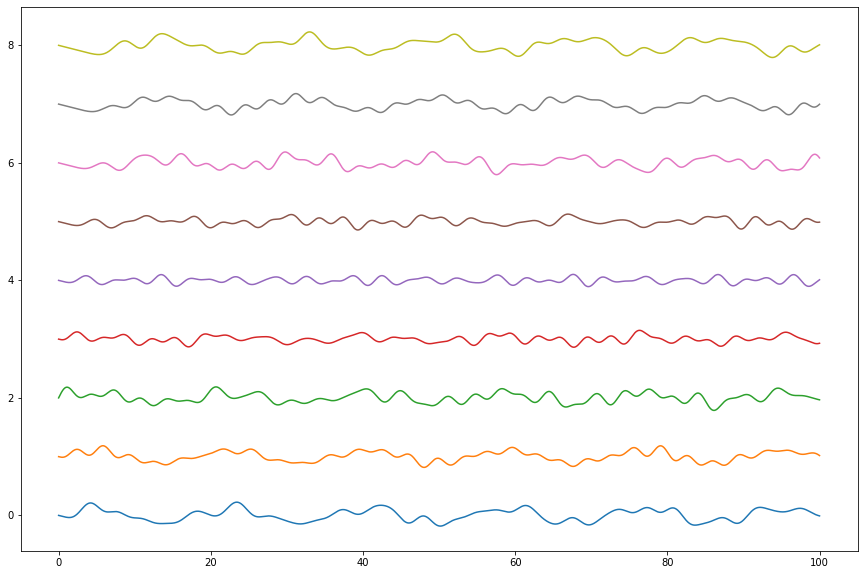

In [11]:
objects[2].displace(0, 0.3)
center(objects)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
plt.figure(figsize = (15,10))
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

Now we have the same situation but with walled boundaries.

In [12]:
end_time = 100
iters = 100000
N = 9
dt = end_time/iters
l = 1
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = 5, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

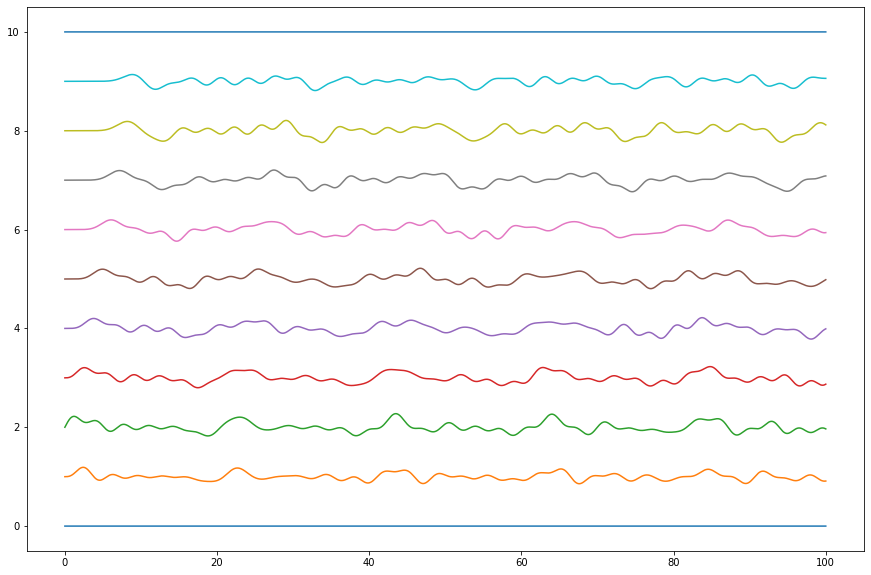

In [13]:
objects[2].displace(0, 0.3)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
        
plt.figure(figsize = (15,10))
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

Same as before except with periodic boundaries.

In [14]:
end_time = 100
iters = 100000
N = 9
dt = end_time/iters
l = 1
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = True
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = 5, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

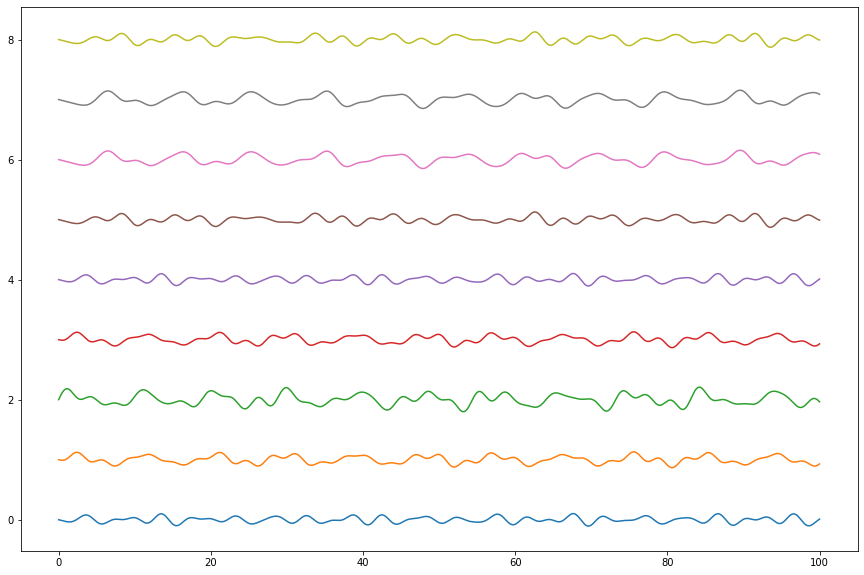

In [15]:
objects[2].displace(0, 0.3)
center(objects)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()

plt.figure(figsize = (15,10))
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

# Normal Modes

We excite the string of springs that we have before into normal modes. First we do this with the walled boundaries and compare it to a theoretical dispersion relationship.

In [16]:
end_time = 10
iters = 100000
N = 4
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(k, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(k, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

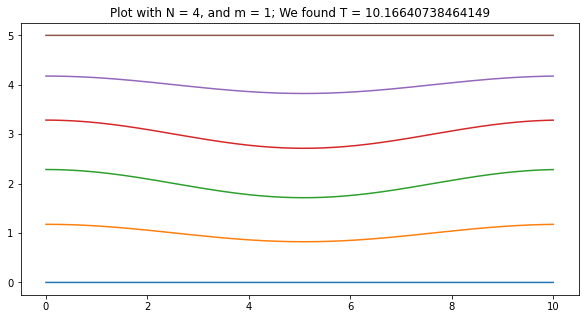

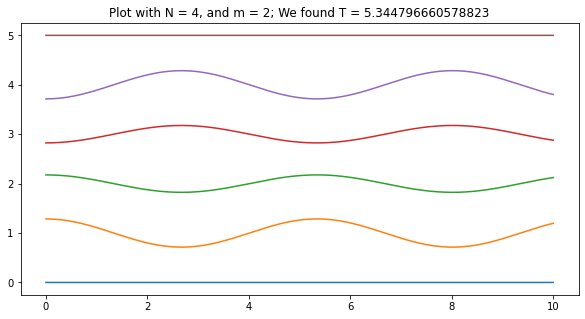

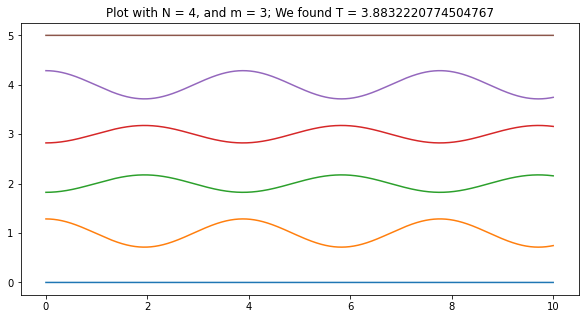

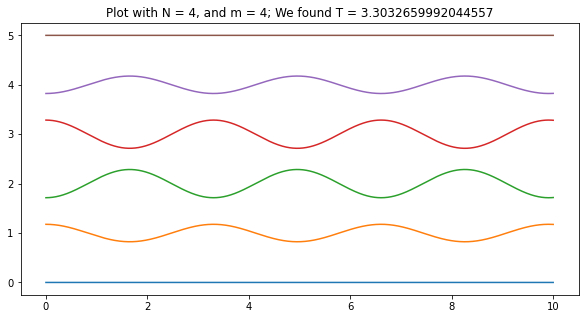

[0.6180339887492279, 1.1755705045847598, 1.618033988750085, 1.9021130325843578]


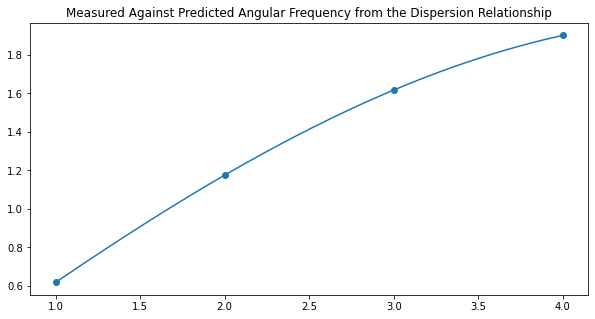

In [17]:
omegas = []
for m in range(1, N + 1):
    lmbda = 2*(N+1)*l/m
    for obj in objects:
        obj.reset()
    n = 0
    for obj in objects:
        deltax = 0.3*np.sin(2*np.pi/lmbda*n*l)
        n += 1
        obj.displace(deltax, 0)
    
    count = 0
    omega_sum = 0
    time = []
    for i in range(iters):
        time.append(i*dt)
        for s in springs:
            s.spring_force()
        for obj in objects:
    #        damping(obj, gamma)
            obj.Newton()
            if not (obj.position - obj.xstart) == 0:
                omega_sum += -obj.acceleration/(obj.position - obj.xstart)
                count += 1
            obj.timestep()
    omega_avg = np.sqrt(omega_sum/count)
    omegas.append(omega_avg)
    period = 2*np.pi/omega_avg
    plt.figure(figsize = (10,5))
    for obj in objects:
        plt.plot(time, obj.xhistory)
    title = "Plot with N = " + str(N) + ", and m = " + str(m) + "; We found T = " + str(period)
    plt.title(title)
    plt.show()

plt.figure(figsize = (10,5))
plt.title("Measured Against Predicted Angular Frequency from the Dispersion Relationship")
plt.scatter(range(1, N+1), omegas)
print(omegas)
i = np.arange(1, N, 0.01)
omega = np.sqrt(2*k/mass*(1 - np.cos(np.pi*i/((N+1)))))
plt.plot(i, omega)
plt.show()

Now we do the same procedure but for periodic boundary conditions.

In [18]:
end_time = 10
iters = 100000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = True
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k, objects[m], objects[m+1],rest_length = l))
    springs.append(spring(k, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

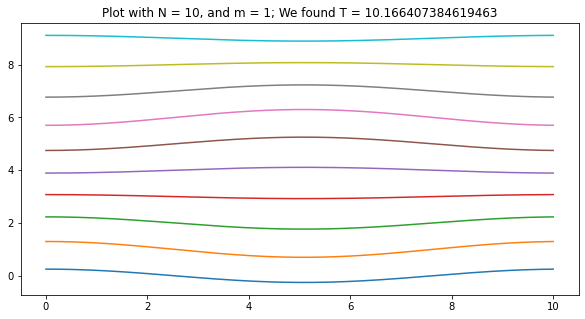

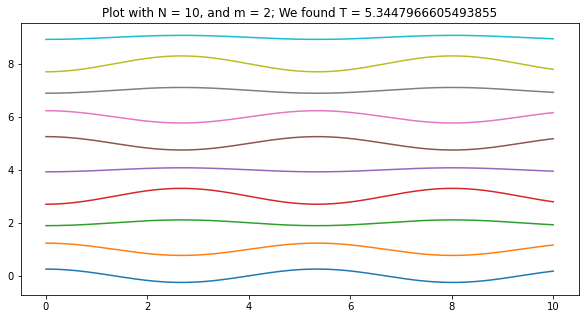

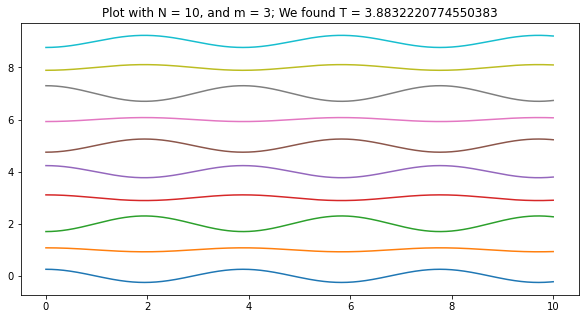

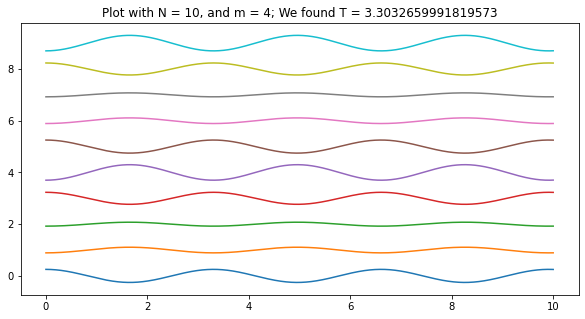

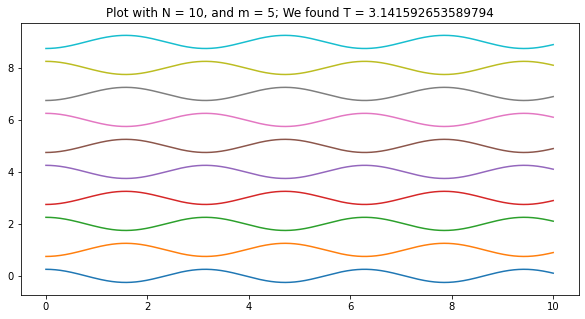

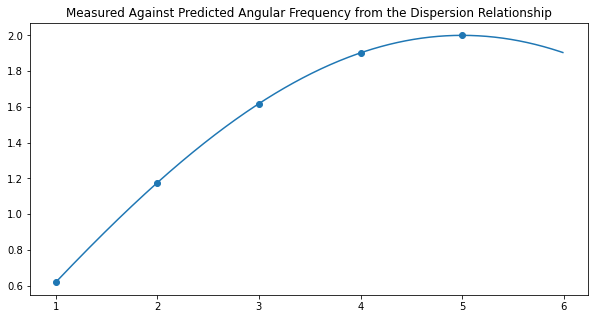

In [19]:
omegas = []
for m in range(1, int((N+1)/2 + 1)):
    lmbda = N*l/m
    for obj in objects:
        obj.reset()
    n = 0
    for obj in objects:
        deltax = 0.3*np.sin(2*np.pi/lmbda*n*l + 1)
        n += 1
        obj.displace(deltax, 0)
    
    count = 0
    omega_sum = 0
    time = []
    for i in range(iters):
        time.append(i*dt)
        for s in springs:
            s.spring_force()
        for obj in objects:
    #        damping(obj, gamma)
            obj.Newton()
            if not (obj.position - obj.xstart) == 0:
                omega_sum += -obj.acceleration/(obj.position - obj.xstart)
                count += 1
            obj.timestep()
    if not count == 0:
        omega_avg = np.sqrt(omega_sum/count)
    else:
        omega_avg = 0
    omegas.append(omega_avg)
    period = 2*np.pi/omega_avg
    plt.figure(figsize = (10,5))
    for obj in objects:
        plt.plot(time, obj.xhistory)
    title = "Plot with N = " + str(N) + ", and m = " + str(m) + "; We found T = " + str(period)
    plt.title(title)
    plt.show()

plt.figure(figsize = (10,5))
plt.title("Measured Against Predicted Angular Frequency from the Dispersion Relationship")
plt.scatter(range(1, int((N+1)/2 + 1)), omegas)
i = np.arange(1, int((N+1)/2 + 1), 0.01)
omega = np.sqrt(2*k/mass*(1 - np.cos(2*np.pi*i/N)))
plt.plot(i, omega)
plt.show()

# Fourier Transform

In [20]:
end_time = 500
iters = 500000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))

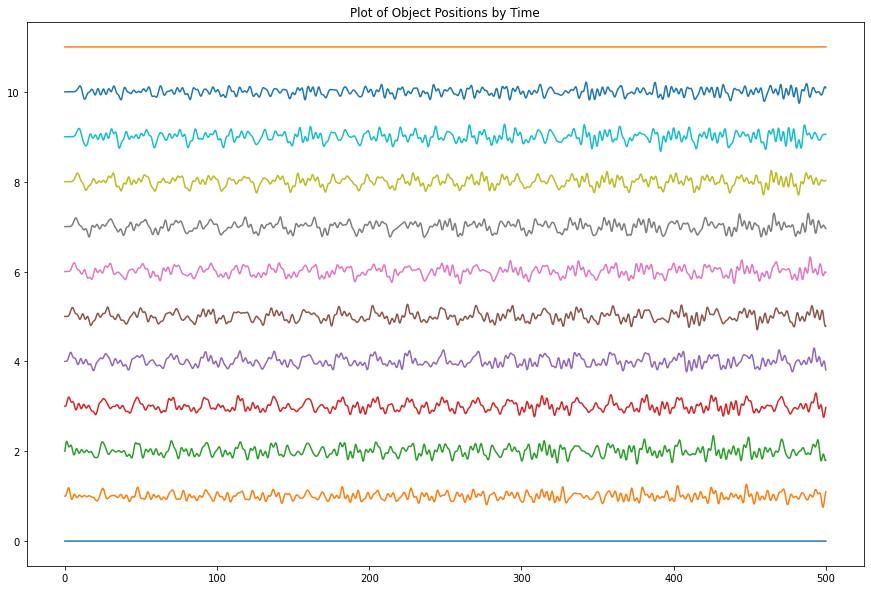

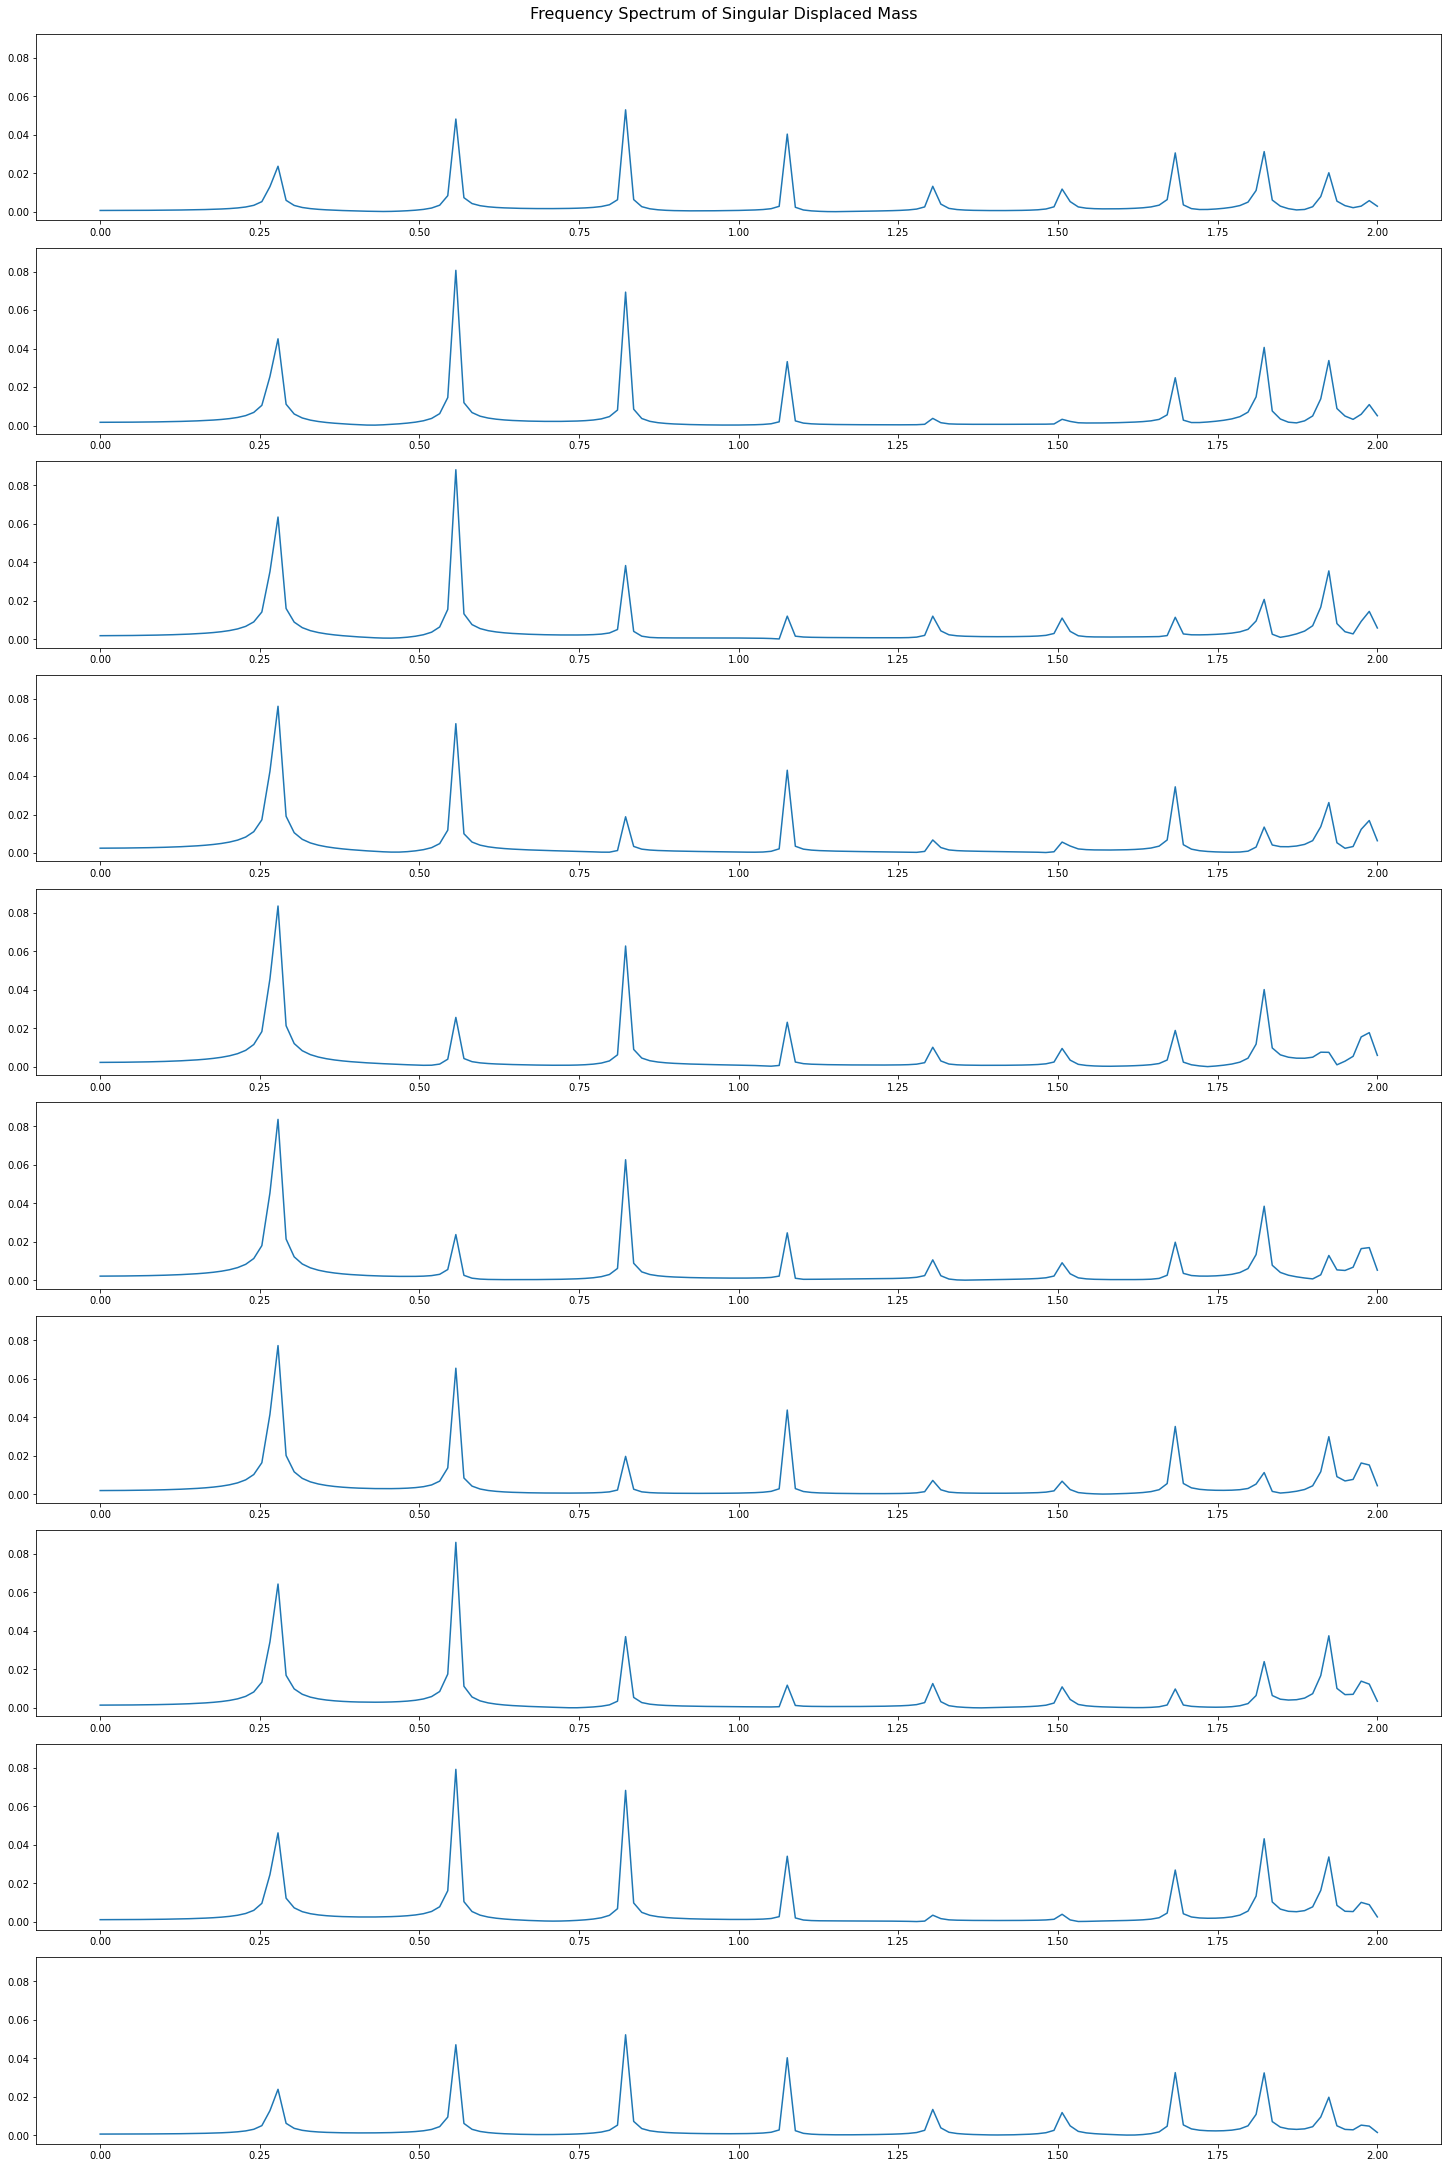

The normal modes for this system are: 0.28462967654657034, 0.5634651136828593, 0.8308300260037726, 1.081281634911195, 1.3097214678905702, 1.5114991487085165, 1.6825070656623622, 1.8192639907090367, 1.9189859472289947, 1.9796428837618656, 


In [21]:
objects[2].displace(0, 0.3)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
plt.figure(figsize = (15,10))
plt.title("Plot of Object Positions by Time")
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

fig, axs = plt.subplots(N, 1, sharey = True, figsize = (20, 3*N), constrained_layout=True)
fig.suptitle("Frequency Spectrum of Singular Displaced Mass", fontsize = 16)
max_freq = 2 / (2 * np.pi)
end_coord = int(max_freq*iters*dt)
graph = 0
for obj in objects[1:N+1]:
    y = obj.xhistory
    yf = np.fft.fft(y)
    yf = 2/iters * np.abs(yf[:iters//2])
    yf = yf[1:end_coord+1]
    xf = 2*np.pi*np.linspace(0.0, max_freq, end_coord)
    axs[graph].plot(xf, yf)
    graph += 1
plt.show()


omegas = []
for m in range(1, N + 1):
    omega = np.sqrt(2*k/mass*(1 - np.cos(np.pi*m/(N+1))))
    omegas.append(omega)

read_out = "The normal modes for this system are: "
for freq in omegas:
    read_out += str(freq) + ", "
print(read_out)

Below, we do the exact same thing except with periodic boundaries

In [22]:
end_time = 500
iters = 500000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = True
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))

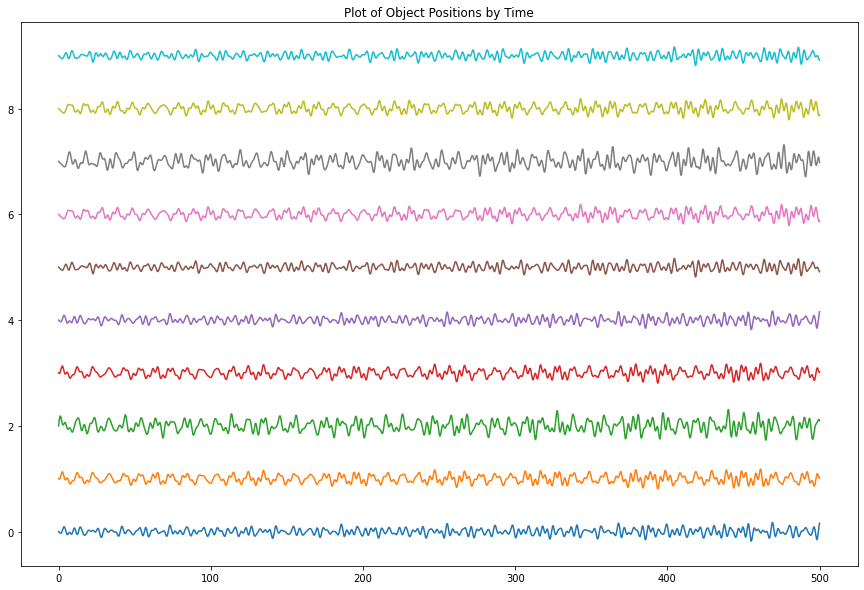

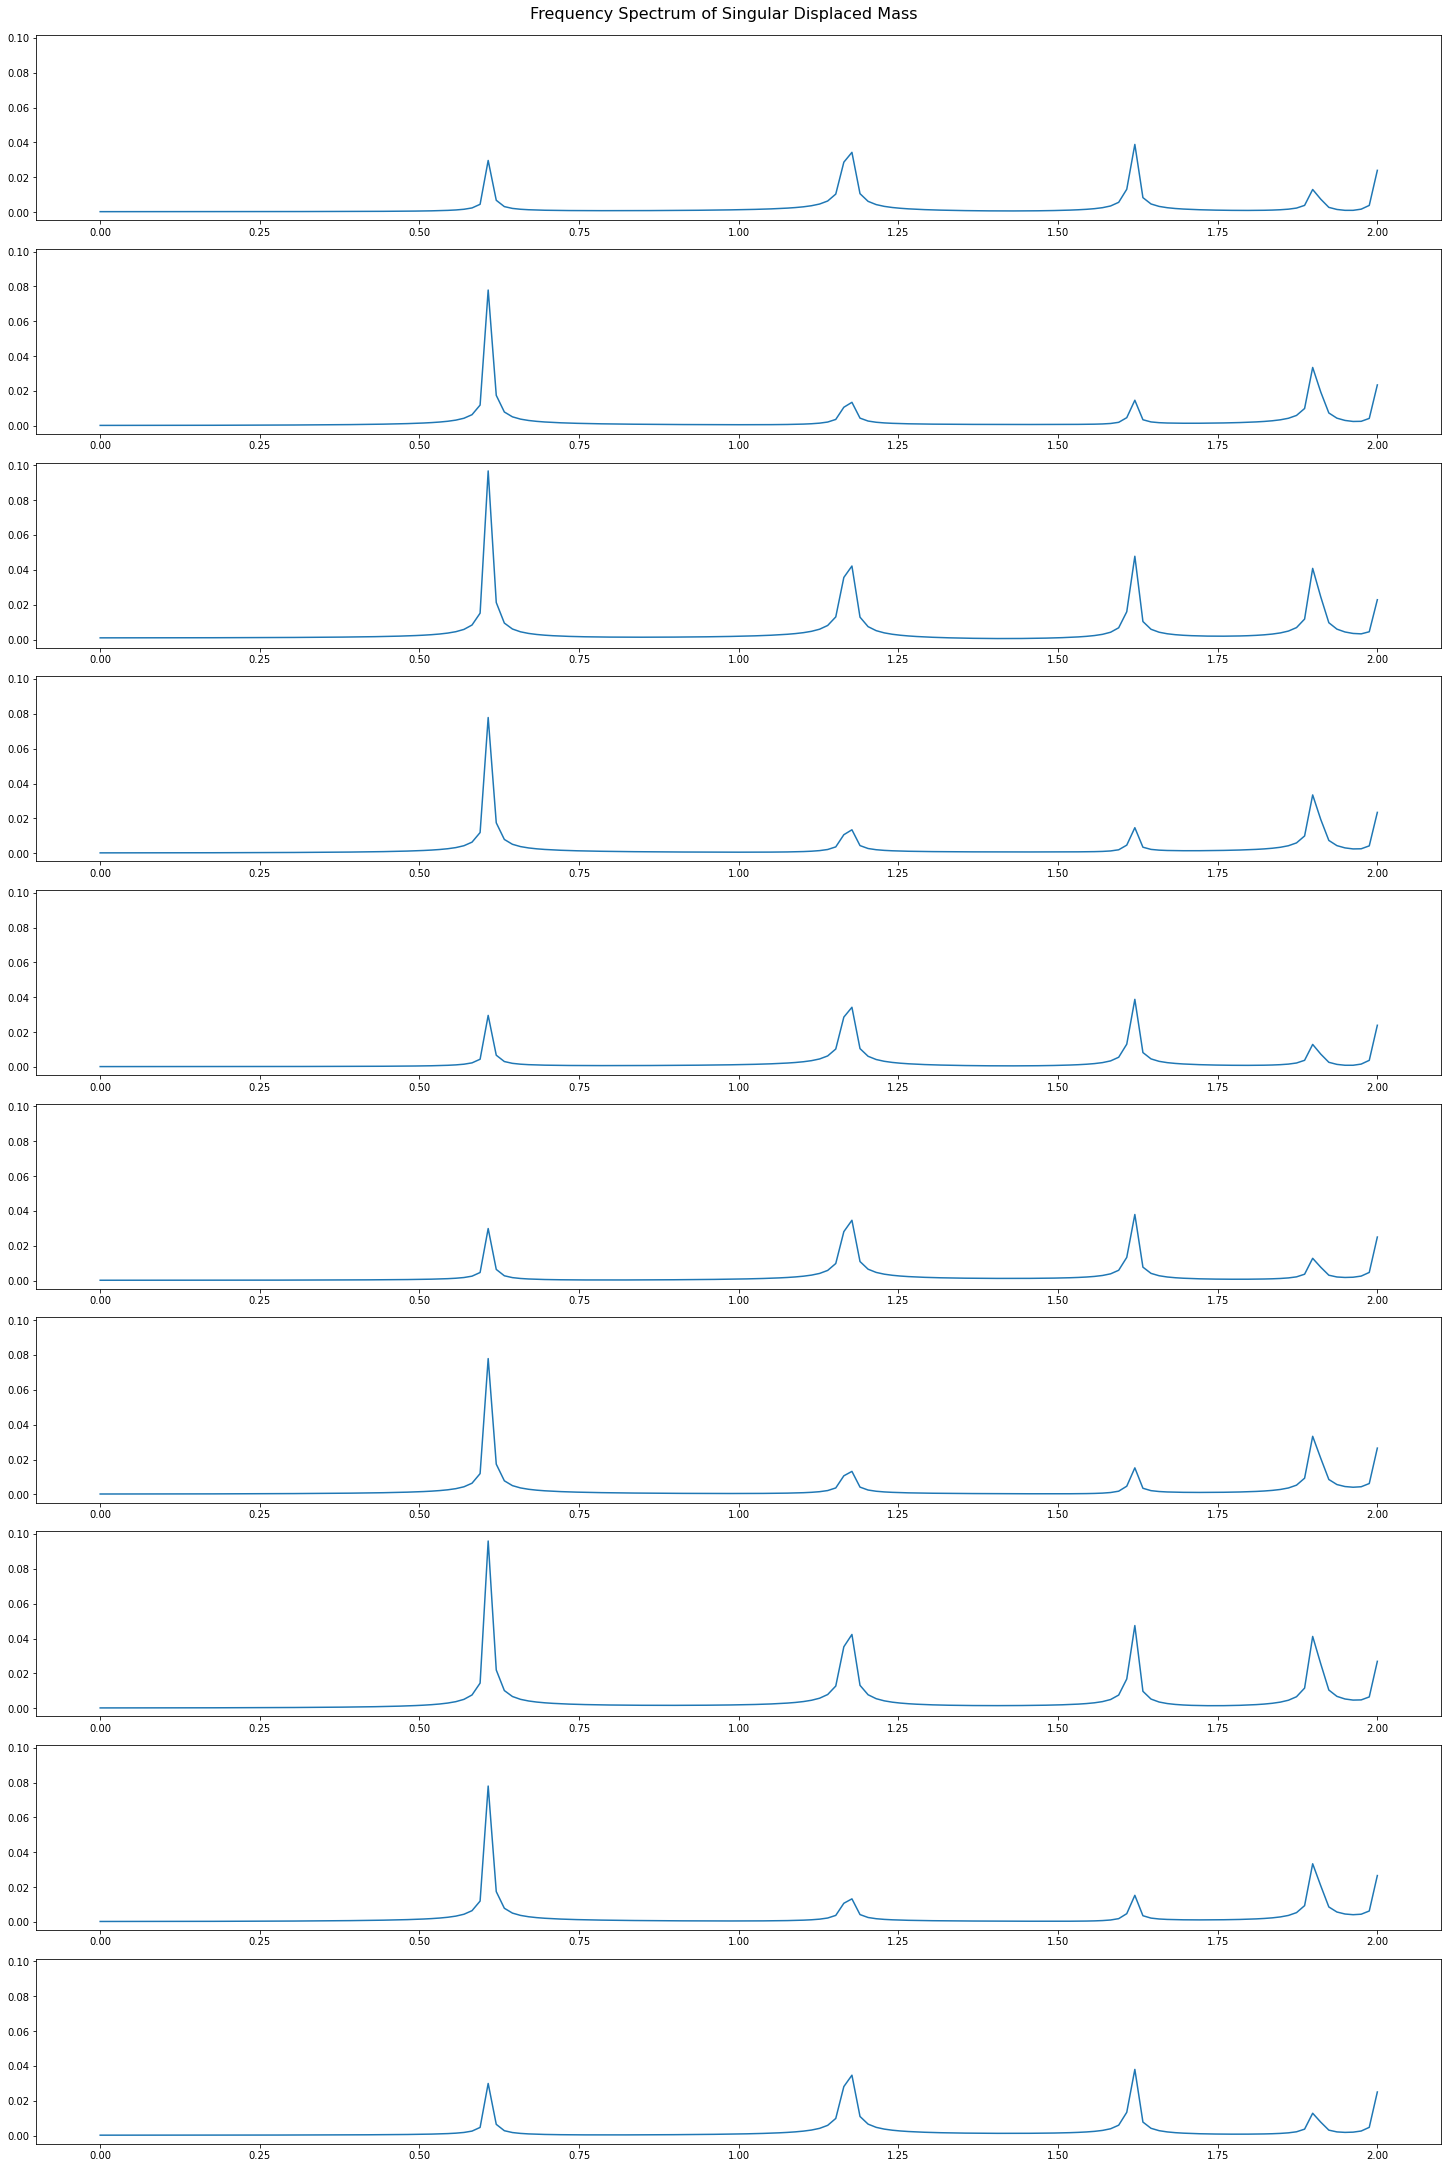

The normal modes for this system are: 0.6180339887498948, 1.1755705045849463, 1.618033988749895, 1.902113032590307, 2.0, 


In [23]:
objects[2].displace(0, 0.3)
center(objects)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
plt.figure(figsize = (15,10))
plt.title("Plot of Object Positions by Time")
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

fig, axs = plt.subplots(N, 1, sharey = True, figsize = (20, 3*N), constrained_layout=True)
fig.suptitle("Frequency Spectrum of Singular Displaced Mass", fontsize = 16)
max_freq = 2 / (2 * np.pi)
end_coord = int(max_freq*iters*dt)
graph = 0
for obj in objects:
    y = obj.xhistory
    yf = np.fft.fft(y)
    yf = 2/iters * np.abs(yf[:iters//2])
    yf = yf[1:end_coord+1]
    xf = 2*np.pi*np.linspace(0.0, max_freq, end_coord)
    axs[graph].plot(xf, yf)
    graph += 1
plt.show()


omegas = []
for m in range(1, int((N+1)/2 + 1)):
    omega = np.sqrt(2*k/mass*(1 - np.cos(2*np.pi*m/N)))
    omegas.append(omega)

read_out = "The normal modes for this system are: "
for freq in omegas:
    read_out += str(freq) + ", "
print(read_out)